In [1]:
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import scanpy as sc
import anndata
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import seaborn as sns
from itertools import chain
#only needed  in development
import importlib # use like this: importlib.reload(typing_comparison.utils)

In [4]:
sys.path.insert(1, '/secure/projects/HTAPP_MBC/src/spatial')
from spatial_utils import *

In [5]:
sample="HTAPP-895-SMP-7359"

In [6]:
#These identifiers are set as defaults in many functions. If names are changed, this has to be adapted when calling the functions.
ct_column='cell_type'
sm_methods=["slide_seq",'exseq'] #spatial mathod names are hard-coded for now because some methods need special treatments. Can be fixed by giving eatch method it's own variable.
sc_method="scRNAseq"
he_method="HE_highres"
all_methods=[sc_method,*sm_methods,he_method]
all_methods

['scRNAseq', 'slide_seq', 'exseq', 'HE_highres']

In [7]:
out_dir=out_dir_base+sample
os.makedirs(out_dir, exist_ok=True)

## Align and prep data

In [16]:
#get the data without processing (Filter: min_genes=30 min_cells=3 but further reduce low count obs if more than 35%)
adatas=get_and_process_data(sample,data_dir,out_dir,methods=all_methods,process=False)

reading  scRNAseq  from buffer
reading  slide_seq  from buffer
reading  exseq  from buffer
Creating HE_highres


In [17]:
#select colors for single cell
sel_colors=colors[colors.index.isin(adatas[sc_method].obs[ct_column])]
adatas[sc_method].obs[ct_column]=pd.Categorical(adatas[sc_method].obs[ct_column], categories=sel_colors.index,ordered=True)
adatas[sc_method].uns[ct_column+"_colors"]=list(sel_colors.values)

In [18]:
#Note: the pre-applied HE scaling factor is 0.4 per default. Take this into account to align to a differently scaled HE. 

registration=pd.DataFrame(index=[i for i in list(replicate_splitter(adatas).index) if not (sc_method in i)] , 
                          columns=["crop_left","crop_right","crop_top","crop_bottom","scale","shift_x","shift_y","degrees"])

#HE 1
registration.loc["HE 1","crop_left"]=1000
registration.loc["HE 1","crop_right"]=400
registration.loc["HE 1","crop_top"]=500
registration.loc["HE 1","crop_bottom"]=200
registration.loc["HE 1","scale"]=0.87
registration.loc["HE 1","degrees"]=0

#Annotation HE 1
registration.loc["HE 1 annot","crop_left"]=0
registration.loc["HE 1 annot","crop_right"]=0
registration.loc["HE 1 annot","crop_top"]=0
registration.loc["HE 1 annot","crop_bottom"]=0
registration.loc["HE 1 annot","scale"]=1
registration.loc["HE 1 annot","degrees"]=0

#exseq 1
registration.loc["exseq 1","shift_x"]=400
registration.loc["exseq 1","shift_y"]=800
registration.loc["exseq 1","degrees"]=134

#slide_seq 1
registration.loc["slide_seq 1","shift_x"]=300
registration.loc["slide_seq 1","shift_y"]=150
registration.loc["slide_seq 1","degrees"]=163


reg_file=out_dir+"/"+sample+"_registration.csv"
if os.path.isfile(reg_file)&False:
    print("Reading registation.")
    registration=pd.read_csv(reg_file,index_col=0)
else:
    print("Writing registration.")
    registration.to_csv(reg_file)

Writing registration.


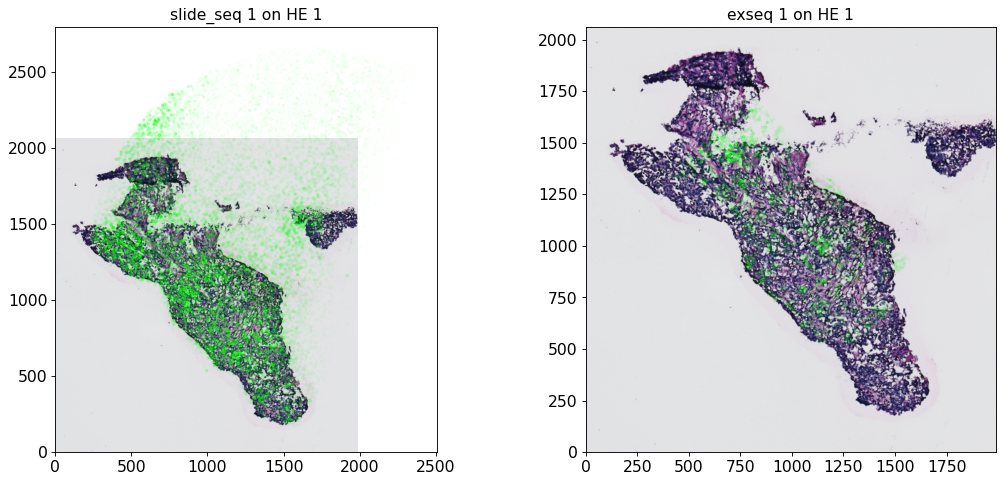

In [20]:
aligner(adatas,img_idx="HE 1",dat_idxs=["slide_seq 1","exseq 1"],registration=registration,figsize=(16,7),adjust=True,change=True)

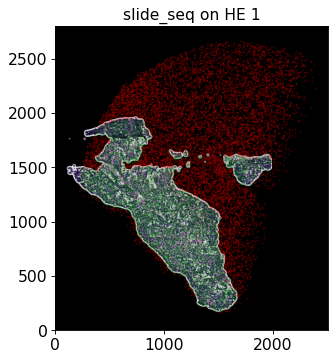

In [21]:
create_mask(adatas, ["HE 1"],dat_idxs=["slide_seq"],figsize=(5,5),dot_sizes=[0.5],s=10,t=0.8)

In [22]:
add_annotations(adatas,sample,dat_idxs=["slide_seq","exseq"],registration=registration)

Fibrosis
Tumor
ImmuneCells
Unidentifiable


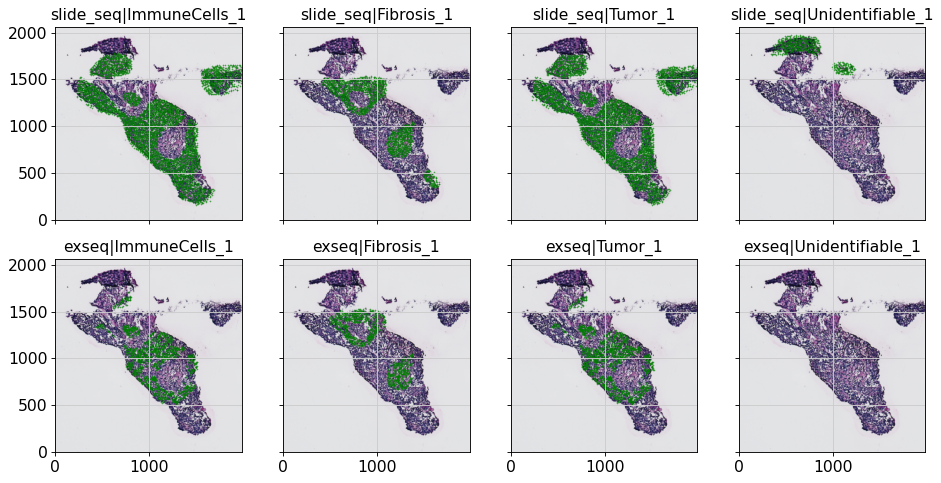

In [26]:
plot_annnotation(adatas,dat_idxs=["slide_seq","exseq"],annots=["ImmuneCells_1","Fibrosis_1","Tumor_1","Unidentifiable_1"],HE="HE 1",figsize=[14,7])

In [27]:
adatas=update_processed_adatas(adatas,sample,out_dir,all_methods,overwrite=True,process=True)

Processing scRNAseq
No HE masks found. Not trimming data.


Trying to set attribute `.obs` of view, copying.


Processing slide_seq
Processing exseq
No HE masks found. Not trimming data.


## Load the processed data

In [28]:
adatas=get_and_process_data(sample,data_dir,out_dir,methods=all_methods)

reading  scRNAseq  from buffer
reading  slide_seq  from buffer
reading  exseq  from buffer
Loading processed HE_highres


## Look at the data

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


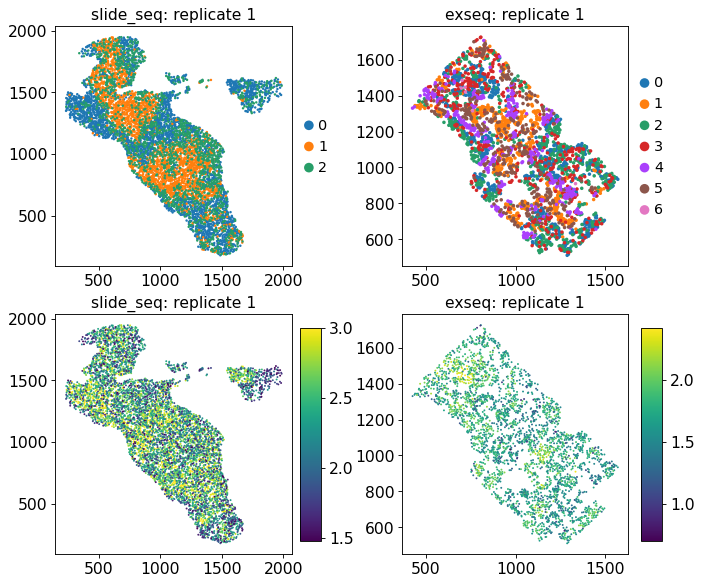

In [29]:
plot_spatial_obs(adatas,sm_methods,axsize=(4,3),wspace=0)

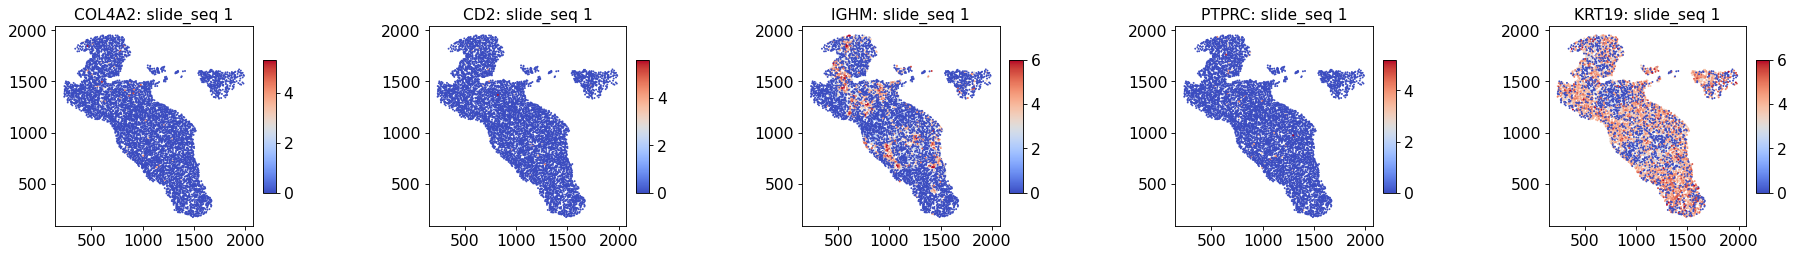

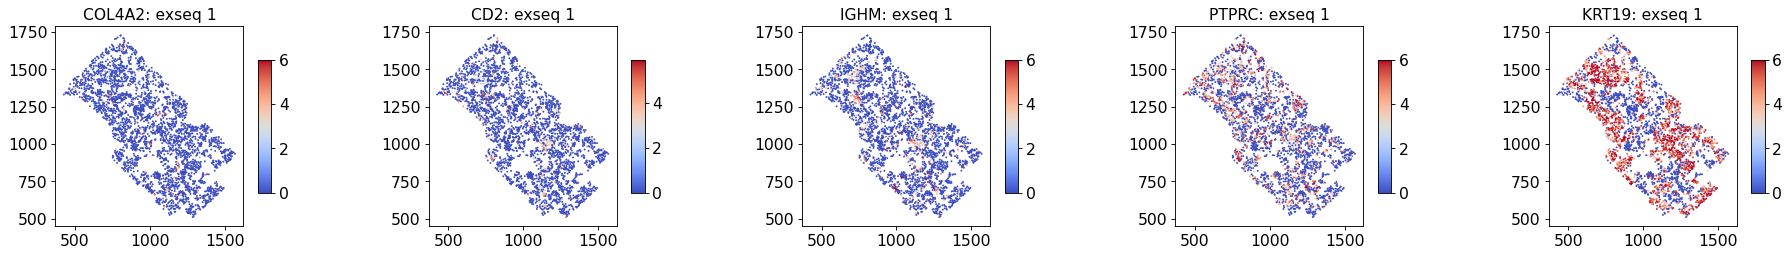

In [42]:
plot_spatial_genes(adatas,methods=sm_methods,genes = ["COL4A2","CD2","IGHM","PTPRC","KRT19"],axsize=(2.5,2.5),x_shifts=[0,-0.04])

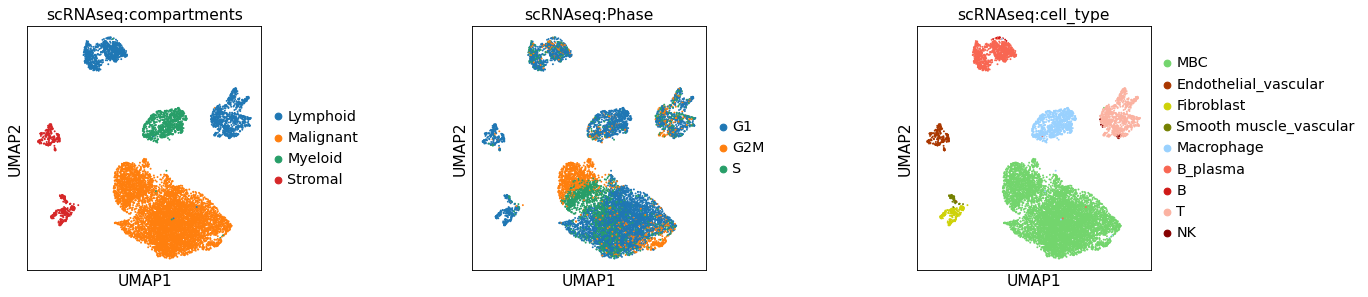

In [36]:
plot_variable_individual(adatas,method_vars=[("scRNAseq","compartments"),("scRNAseq","Phase"),("scRNAseq","cell_type")])

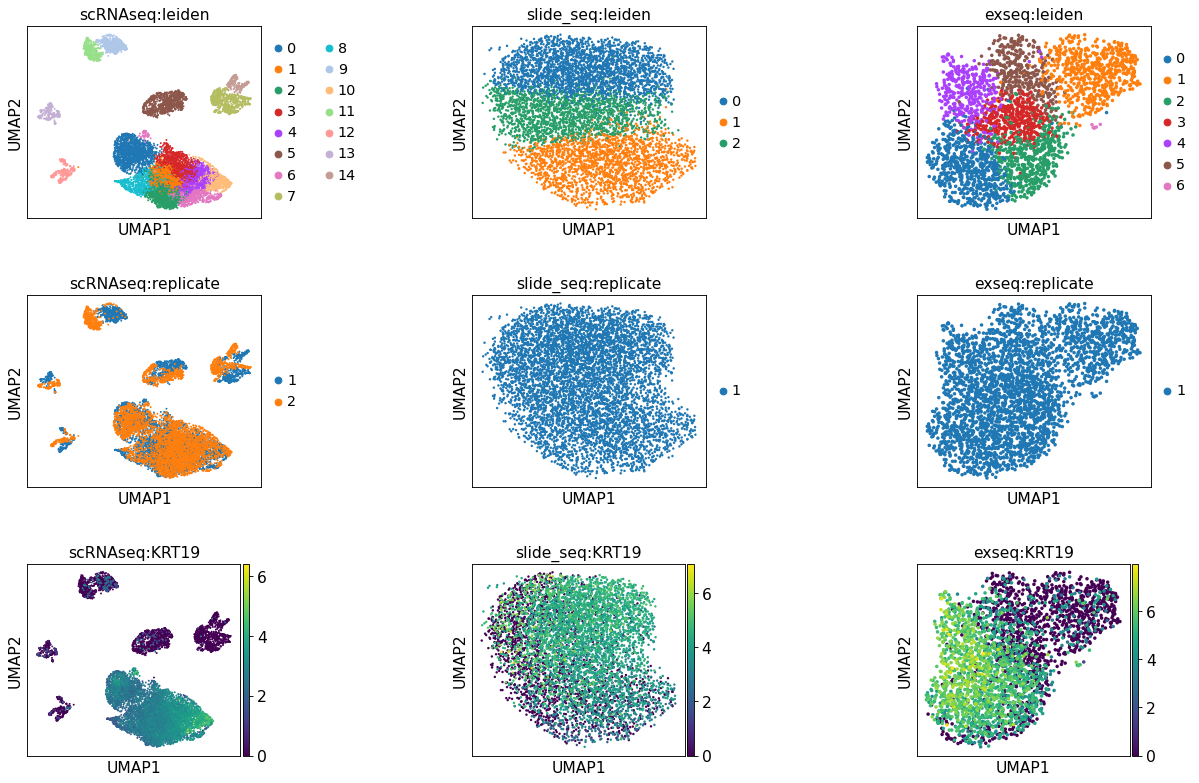

In [37]:
plot_variable_grid(adatas,methods=[sc_method,*sm_methods],variables=['leiden','replicate','KRT19'])

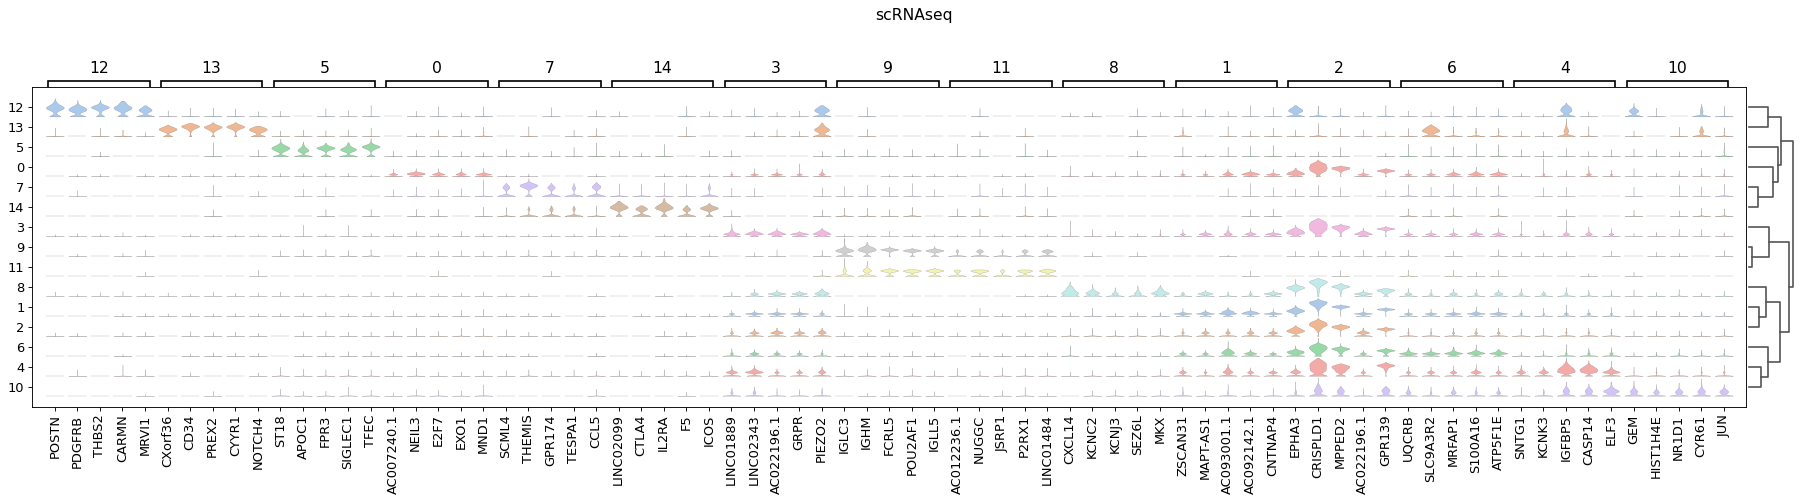

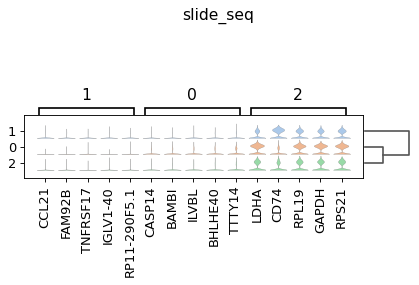

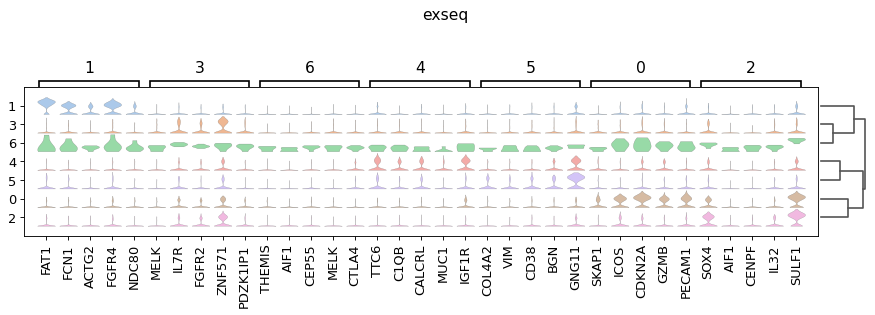

In [38]:
get_sub_markers(adatas,methods=[sc_method,*sm_methods],rest_thres=1)